### Train a model on our prepared data and features

In this notebook, we take the features that we generated and train different ML models on it to assess the predictiveness of the features and eventually create a good model.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 40)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_pickle('../datasets/processed_clean/business_data_processed.pkl')
df = df.drop(df[df['is_closed'] == 0].sample(frac=.7).index) # delete 70 percent of non-closed restaurants

Let's take a look at our dataframe created by merging the old and new datasets and creating the new features.

In [3]:
df.head(3)

,business_id,business_name,categories,city,full_address,display_phone,review_count,stars,price_tag,is_claimed,is_closed,image,url,latitude,longitude,reviews_per_week,oldest_review,std_of_stars,median_of_stars,votes_per_week,stars_linear_coef,business_density,business_similar_density,zprice_all,zreview_count_all,zreview_per_week_all,zstar_all,is_chain
2,7dadd1a8-f799-459b-bad1-dba165669780,Calme Palase,"[Bar, Cafe, European, Pub]",Vlore County,"Rruga E Plazhit Te Palases, Palase Albania",None,3.0,2.5,1.0,False,False,"data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEK...",https://www.tripadvisor.com/Restaurant_Review-...,40.170204,19.583406,0.021649,138.571429,1.885618,1.0,0.036082,-0.000023,3.0,8.0,0.000000,0.000000,0.0,-0.066667,False
6,783c8371-6e20-4280-802e-ae3b1cd36294,Camping paradise,"[Cafe, Seafood, European]",Vlore County,"Perivol, Dhermi Albania",+355 67 289 3807,105.0,4.5,1.0,True,True,"data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEK...",https://www.tripadvisor.com/Restaurant_Review-...,40.153465,19.615965,0.166667,90.000000,0.997775,5.0,0.055556,0.000901,24.0,29.0,-0.218750,0.694202,0.0,0.254167,False
8,e29184a7-00ed-4ff1-b096-6b3d044dd94d,Aloni Restaurant,"[Seafood, European, Diner]",Vlore County,"Plazhi i Dhermiut, Dhermi 9422 Albania",+355 67 204 1982,79.0,3.5,1.0,True,False,"data:image/gif;base64,R0lGODlhAQABAAAAACH5BAEK...",https://www.tripadvisor.com/Restaurant_Review-...,40.142868,19.638182,0.060172,249.285714,1.366260,5.0,0.024069,-0.000371,31.0,28.0,-0.157258,0.430533,0.0,0.009677,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1622 entries, 2 to 4054
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   business_id               1622 non-null   object 
 1   business_name             1622 non-null   object 
 2   categories                1622 non-null   object 
 3   city                      1622 non-null   object 
 4   full_address              1622 non-null   object 
 5   display_phone             1412 non-null   object 
 6   review_count              1622 non-null   float64
 7   stars                     1622 non-null   float64
 8   price_tag                 1622 non-null   float64
 9   is_claimed                1622 non-null   bool   
 10  is_closed                 1622 non-null   bool   
 11  image                     1223 non-null   object 
 12  url                       1622 non-null   object 
 13  latitude                  1622 non-null   float64
 14  longitud

In [5]:
df.columns

Index(['business_id', 'business_name', 'categories', 'city', 'full_address',
       'display_phone', 'review_count', 'stars', 'price_tag', 'is_claimed',
       'is_closed', 'image', 'url', 'latitude', 'longitude',
       'reviews_per_week', 'oldest_review', 'std_of_stars', 'median_of_stars',
       'votes_per_week', 'stars_linear_coef', 'business_density',
       'business_similar_density', 'zprice_all', 'zreview_count_all',
       'zreview_per_week_all', 'zstar_all', 'is_chain'],
      dtype='object')

Percentage of closed restaurants? Might not be good!

In [6]:
len(df[df['is_closed'] == 0])/len(df)

0.6411837237977805

Text(0, 0.5, 'Total Number of Restaurants')

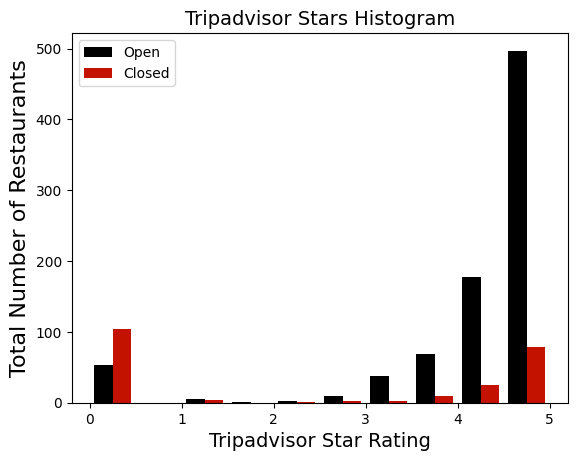

In [7]:
plt.hist([df[df['is_closed']==0].dropna()['stars'].values,\
          df[df['is_closed']==1].dropna()['stars'].values],\
        label=['Open','Closed'],color=['k','#c41200'])


plt.legend()
plt.title('Tripadvisor Stars Histogram',fontsize=14)
plt.xlabel('Tripadvisor Star Rating',fontsize=14)
plt.ylabel('Total Number of Restaurants',fontsize=16)

Text(0, 0.5, 'Integral Value')

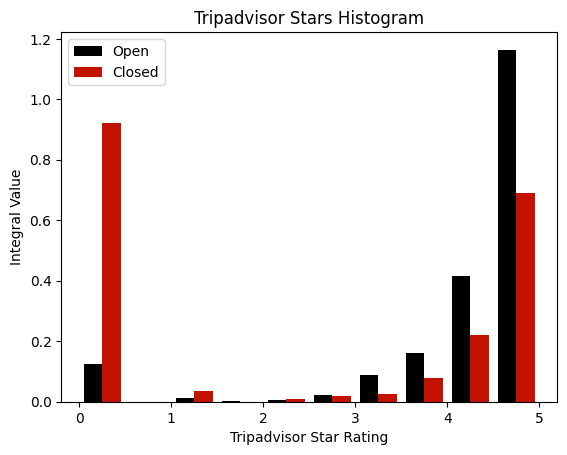

In [8]:
# The normed option normalizes in a way that the integral is 1 that means that the y-axis is not the percentage
plt.hist([df[df['is_closed']==0].dropna()['stars'].values,\
          df[df['is_closed']==1].dropna()['stars'].values],\
        label=['Open','Closed'],color=['k','#c41200'], density=True)


plt.legend()
plt.title('Tripadvisor Stars Histogram')
plt.xlabel('Tripadvisor Star Rating')
plt.ylabel('Integral Value')

Text(0, 0.5, 'Percentages per Category (%)')

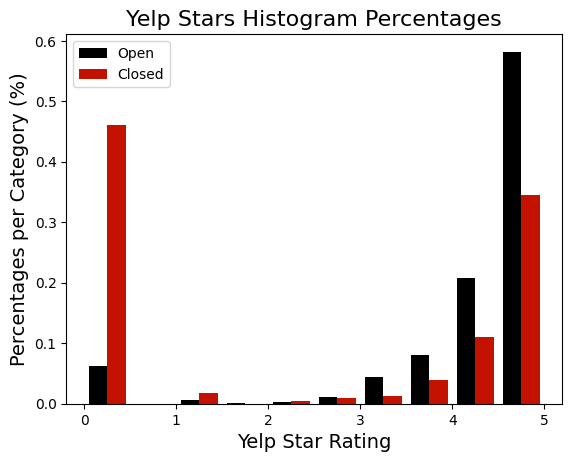

In [9]:
open_length = len(df[df['is_closed']==0].dropna()['stars'])
closed_length = len(df[df['is_closed']==1].dropna()['stars'])
weights = [np.ones(open_length)/open_length,np.ones(closed_length)/closed_length]
plt.hist([df[df['is_closed']==0].dropna()['stars'].values,\
          df[df['is_closed']==1].dropna()['stars'].values],\
        label=['Open','Closed'],color=['k','#c41200'],weights=weights)


plt.legend()
plt.title('Yelp Stars Histogram Percentages',fontsize=16)
plt.xlabel('Yelp Star Rating',fontsize=14)
plt.ylabel('Percentages per Category (%)',fontsize=14)

Text(0.5, 0, 'Total Number of Reviews')

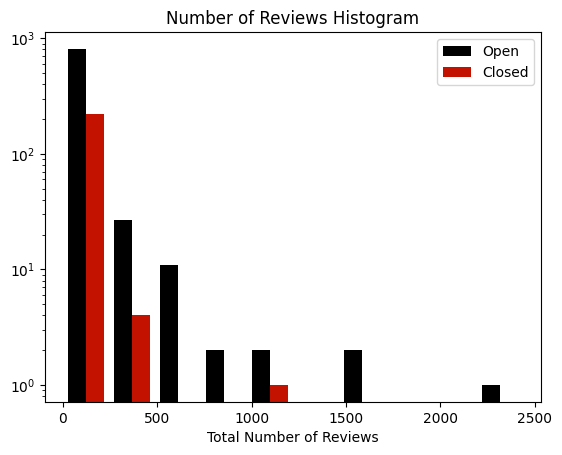

In [10]:
plt.hist([df[df['is_closed']==0].dropna()['review_count'].values,\
          df[df['is_closed']==1].dropna()['review_count'].values],\
        label=['Open','Closed'],color=['k','#c41200'],log=True)


plt.legend()
plt.title('Number of Reviews Histogram')
plt.xlabel('Total Number of Reviews')

Text(0.5, 1.0, 'Price')

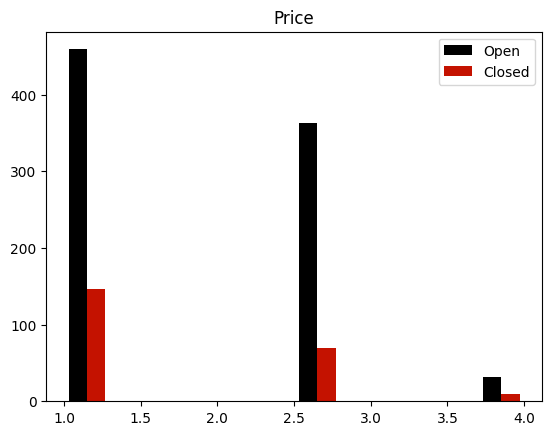

In [11]:
plt.hist([df[df['is_closed']==0].dropna()['price_tag'].values,\
          df[df['is_closed']==1].dropna()['price_tag'].values],\
        label=['Open','Closed'],color=['k','#c41200'])


plt.legend()
plt.title('Price')

In [12]:
df_ml = df[['review_count','stars','price_tag','oldest_review','std_of_stars','reviews_per_week',\
            'median_of_stars','votes_per_week','stars_linear_coef','business_density',\
            'business_similar_density','zreview_count_all','zstar_all','zprice_all','zreview_per_week_all',\
            'is_claimed','is_chain','is_closed']]

In [13]:
len(df_ml)

1622

In [14]:
for column in ['is_claimed', 'is_chain', 'is_closed']:
    df_ml[column] = df_ml[column].apply(lambda x: int(x))

/var/folders/tr/qq7qwqx91mq6jv07l_3ksqlm0000gn/T/ipykernel_98546/74214307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml[column] = df_ml[column].apply(lambda x: int(x))


In [15]:
df_ml_features = df_ml.drop('is_closed', axis=1)
df_ml_target = df_ml['is_closed']

In [16]:
# Try different classification techniques
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, precision_score, recall_score, matthews_corrcoef, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

logistic_model = LogisticRegression(random_state=0, max_iter=2000)
gaussian_model = GaussianNB()
decision_tree_model = DecisionTreeClassifier(random_state=1)
gradient_boosting_model = GradientBoostingClassifier(random_state=1)
random_forest_model = RandomForestClassifier(random_state=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_ml_features, df_ml_target, test_size = 0.2, random_state = 10,\
                                                    stratify = df_ml_target)

In [18]:
logistic_model.fit(X_train,list(y_train.values))
y_pred = logistic_model.predict(X_test)
print('Accuracy: ', logistic_model.score(X_test,list(y_test.values)))
print('Mathews:', matthews_corrcoef(y_test.values, y_pred))
print('Precision: ', precision_score(list(y_test.values),y_pred))
print('Recall: ', recall_score(list(y_test.values),y_pred))
print('F1 Score: ', f1_score(list(y_test.values),y_pred))
print('AUC:', roc_auc_score(y_test.values, y_pred))
print('Confusion Matrix: \n',confusion_matrix(list(y_test.values), y_pred))

Accuracy:  0.8338461538461538
Mathews: 0.6381270399870553
Precision:  0.7739130434782608
Recall:  0.7606837606837606
F1 Score:  0.7672413793103448
AUC: 0.8178418803418803
Confusion Matrix: 
 [[182  26]
 [ 28  89]]


In [19]:
gaussian_model.fit(X_train,list(y_train.values))
y_pred = gaussian_model.predict(X_test)
print('Accuracy: ', gaussian_model.score(X_test,list(y_test.values)))
print('Mathews:', matthews_corrcoef(y_test.values, y_pred))
print('Precision: ', precision_score(list(y_test.values),y_pred))
print('Recall: ', recall_score(list(y_test.values),y_pred))
print('F1 Score: ', f1_score(list(y_test.values),y_pred))
print('AUC:', roc_auc_score(y_test.values, y_pred))
print('Confusion Matrix: \n',confusion_matrix(list(y_test.values), y_pred))

Accuracy:  0.6892307692307692
Mathews: 0.4239844420734695
Precision:  0.5449438202247191
Recall:  0.8290598290598291
F1 Score:  0.6576271186440678
AUC: 0.7198183760683762
Confusion Matrix: 
 [[127  81]
 [ 20  97]]


In [20]:
decision_tree_model.fit(X_train,list(y_train.values))
y_pred = decision_tree_model.predict(X_test)
print('Accuracy: ', decision_tree_model.score(X_test,list(y_test.values)))
print('Mathews:', matthews_corrcoef(y_test.values, y_pred))
print('Precision: ', precision_score(list(y_test.values),y_pred))
print('Recall: ', recall_score(list(y_test.values),y_pred))
print('F1 Score: ', f1_score(list(y_test.values),y_pred))
print('AUC:', roc_auc_score(y_test.values, y_pred))
print('Confusion Matrix: \n',confusion_matrix(list(y_test.values), y_pred))

Accuracy:  0.7569230769230769
Mathews: 0.47552596515973977
Precision:  0.6583333333333333
Recall:  0.6752136752136753
F1 Score:  0.6666666666666666
AUC: 0.7390491452991453
Confusion Matrix: 
 [[167  41]
 [ 38  79]]


In [21]:
gradient_boosting_model.fit(X_train,list(y_train.values))
y_pred = gradient_boosting_model.predict(X_test)
print('Accuracy: ', gradient_boosting_model.score(X_test,list(y_test.values)))
print('Mathews:', matthews_corrcoef(y_test.values, y_pred))
print('Precision: ', precision_score(list(y_test.values),y_pred))
print('Recall: ', recall_score(list(y_test.values),y_pred))
print('F1 Score: ', f1_score(list(y_test.values),y_pred))
print('AUC:', roc_auc_score(y_test.values, y_pred))
print('Confusion Matrix: \n',confusion_matrix(list(y_test.values), y_pred))

Accuracy:  0.8276923076923077
Mathews: 0.6195711794204491
Precision:  0.7904761904761904
Recall:  0.7094017094017094
F1 Score:  0.7477477477477478
AUC: 0.8018162393162395
Confusion Matrix: 
 [[186  22]
 [ 34  83]]


In [22]:
random_forest_model.fit(X_train,list(y_train.values))
y_pred = random_forest_model.predict(X_test)
print('Accuracy: ', random_forest_model.score(X_test,list(y_test.values)))
print('Mathews:', matthews_corrcoef(y_test.values, y_pred))
print('Precision: ', precision_score(list(y_test.values),y_pred))
print('Recall: ', recall_score(list(y_test.values),y_pred))
print('F1 Score: ', f1_score(list(y_test.values),y_pred))
print('AUC:', roc_auc_score(y_test.values, y_pred))
print('Confusion Matrix: \n',confusion_matrix(list(y_test.values), y_pred))

Accuracy:  0.84
Mathews: 0.64569938542176
Precision:  0.8282828282828283
Recall:  0.7008547008547008
F1 Score:  0.7592592592592592
AUC: 0.8095619658119657
Confusion Matrix: 
 [[191  17]
 [ 35  82]]


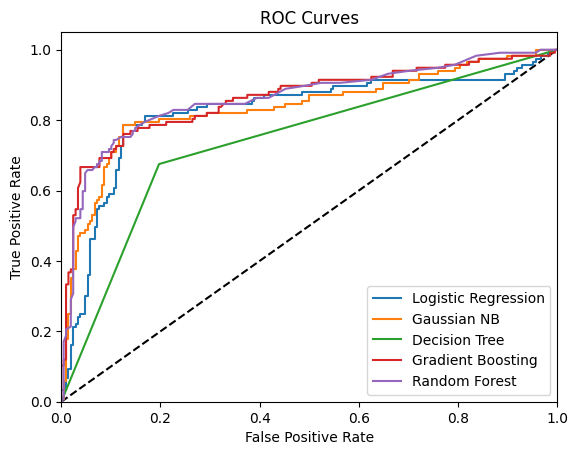

In [23]:
y_score = logistic_model.decision_function(X_test)
y_score_A = gaussian_model.predict_proba(X_test)[:,1]
y_score_B = decision_tree_model.predict_proba(X_test)[:,1]
y_score_C = gradient_boosting_model.decision_function(X_test)
y_score_D = random_forest_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test.values,y_score)
fpr_A, tpr_A, _ = roc_curve(y_test.values,y_score_A)
fpr_B, tpr_B, _ = roc_curve(y_test.values,y_score_B)
fpr_C, tpr_C, _ = roc_curve(y_test.values,y_score_C)
fpr_D, tpr_D, _ = roc_curve(y_test.values,y_score_D)
plt.plot([0,1],[0,1],'k--')

plt.plot(fpr,tpr,label='Logistic Regression')
plt.plot(fpr_A,tpr_A,label='Gaussian NB')
plt.plot(fpr_B,tpr_B,label='Decision Tree')
plt.plot(fpr_C,tpr_C,label='Gradient Boosting')
plt.plot(fpr_D,tpr_D,label='Random Forest')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()